# ``graspologic`` demo

In [34]:
!pip install graspologic --pre

In [35]:
import graspologic

graspologic.__version__

'3.0.0.dev4997377482'

## Loading some data

For these examples I'll use the recently published connectome of a *Drosophila* larva brain.

In [36]:
import pandas as pd

edges = pd.read_csv(
    "https://raw.githubusercontent.com/neurodata/neuropull/main/data/maggot_brain/edgelist.csv.gz"
)
edges[["source", "target", "weight"]]

,source,target,weight
0,29,2506050,1
1,29,3347834,4
2,29,3522293,4
3,29,3886356,3
4,29,3890028,1
...,...,...,...
110672,21591317,17729088,4
110673,21591317,17777259,1
110674,21591317,20278329,1
110675,21591317,20443420,1


In [37]:
nodes = pd.read_csv(
    "https://raw.githubusercontent.com/neurodata/neuropull/main/data/maggot_brain/nodes.csv.gz",
    index_col=0,
)
nodes[["side", "pair"]]

,side,pair
node_id,,
2206279,left,2
2216445,left,5
2215247,left,7
10241716,left,8
2216131,left,11
...,...,...
8978117,right,1641
8957325,right,1642
6978516,right,1643


In [38]:
def edges_to_adjacency(edges, source_index, target_index=None):
    if target_index is None:
        target_index = source_index
    adjacency = (
        pd.crosstab(edges["source"], edges["target"], edges["weight"], aggfunc="sum")
        .reindex(index=source_index, columns=target_index)
        .fillna(0)
    )
    adjacency.index.name = "source"
    adjacency.columns.name = "target"
    return adjacency


adjacency = edges_to_adjacency(edges, nodes.index).values
adjacency

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [100]:
left_nodes = nodes_lcc.query("side == 'left'")
right_nodes = nodes_lcc.query("side == 'right'")

left_adjacency = edges_to_adjacency(edges, left_nodes.index, left_nodes.index).values
right_adjacency = edges_to_adjacency(edges, right_nodes.index, right_nodes.index).values

left_labels = left_nodes["super_class"].values
right_labels = right_nodes["super_class"].values

In [104]:
from graspologic.match import graph_match
from graspologic.simulations import er_np

Number of edge disagreements:  168.0


<Axes: title={'center': 'Difference'}>

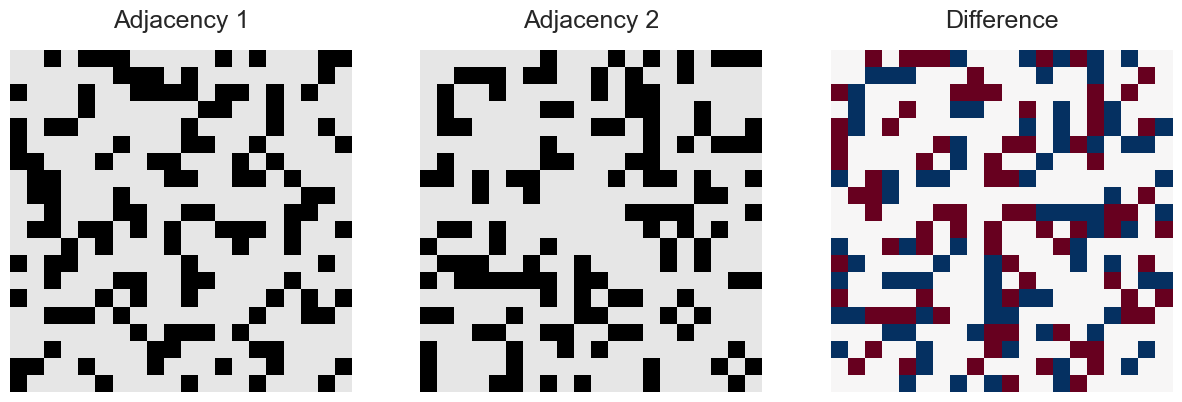

In [105]:
import matplotlib.pyplot as plt

In [114]:
misc[0]

{'score': 1004556.0,
 'n_iter': 30,
 'convex_solution': array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'converged': False}

## Putting it all together

In [151]:
left_pn_nodes = left_nodes.query("(super_class == 'PN') & has_valid_pair")
right_pn_nodes = right_nodes.query("super_class == 'PN' & has_valid_pair")
left_kc_nodes = left_nodes.query("super_class == 'KC'").sample(frac=1)
right_kc_nodes = right_nodes.query("super_class == 'KC'").sample(frac=1)

In [152]:
left_pn_nodes = left_pn_nodes.sort_values("pair")
right_pn_nodes = right_pn_nodes.sort_values("pair")

assert (left_pn_nodes["pair"].values == right_pn_nodes["pair"].values).all()

In [153]:
partial_match = np.stack(
    (np.arange(len(left_pn_nodes)), np.arange(len(right_pn_nodes)))
).T
partial_match.shape

(103, 2)

In [154]:
left_index = np.concatenate((left_pn_nodes.index, left_kc_nodes.index))
right_index = np.concatenate((right_pn_nodes.index, right_kc_nodes.index))

left_subgraph_adjacency = edges_to_adjacency(edges, left_index, left_index).values
right_subgraph_adjacency = edges_to_adjacency(edges, right_index, right_index).values

<Axes: >

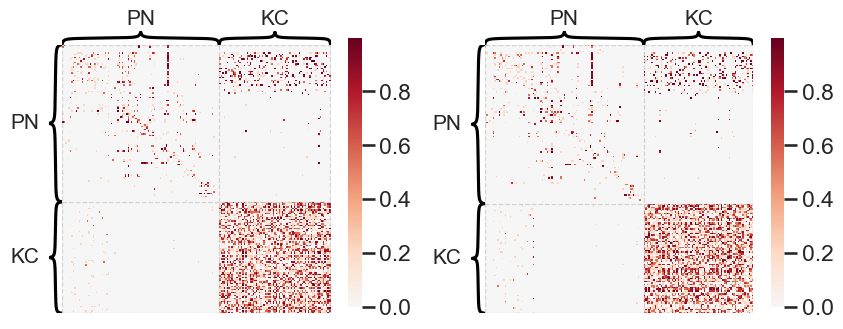

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

left_labels = left_nodes.loc[left_index, "super_class"].values
right_labels = right_nodes.loc[right_index, "super_class"].values

heatmap(
    left_subgraph_adjacency,
    transform="simple-nonzero",
    inner_hier_labels=left_labels,
    hier_label_fontsize=15,
    ax=axs[0],
)
heatmap(
    right_subgraph_adjacency,
    transform="simple-nonzero",
    inner_hier_labels=right_labels,
    hier_label_fontsize=15,
    ax=axs[1],
)

In [156]:
left_permutation, right_permutation, score, misc = graph_match(
    left_subgraph_adjacency, right_subgraph_adjacency, partial_match=partial_match
)
score

56141.0

<Axes: >

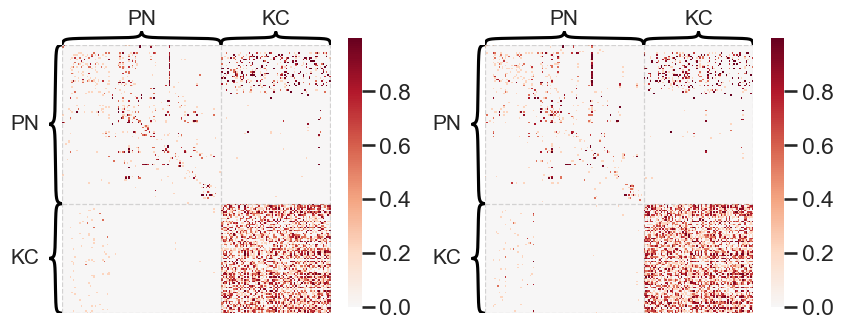

In [157]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

heatmap(
    left_subgraph_adjacency[left_permutation][:, left_permutation],
    transform="simple-nonzero",
    inner_hier_labels=left_labels[left_permutation],
    hier_label_fontsize=15,
    ax=axs[0],
)
heatmap(
    right_subgraph_adjacency[right_permutation][:, right_permutation],
    transform="simple-nonzero",
    inner_hier_labels=right_labels[right_permutation],
    hier_label_fontsize=15,
    ax=axs[1],
)

In [260]:
nodes["super_class"].value_counts()

super_class
pre-DN-VNC    478
sensory       434
other         374
KC            222
PN            206
LHN           202
DN-VNC        182
DN-SEZ        164
PN-somato     152
LN            110
MB-FBN        108
pre-DN-SEZ    102
CN            100
RGN            54
MB-FFN         54
MBON           48
ascending      46
MBIN           30
Name: count, dtype: int64

In [297]:
# left_index = left_kc_nodes.index
# right_index = right_kc_nodes.index

left_index = left_nodes.query("super_class == 'KC'").index
right_index = right_nodes.query("super_class == 'KC'").index

left_subgraph_adjacency = edges_to_adjacency(edges, left_index, left_index).values
right_subgraph_adjacency = edges_to_adjacency(edges, right_index, right_index).values

# left_subgraph_adjacency[left_subgraph_adjacency <= 2] = 0
# right_subgraph_adjacency[right_subgraph_adjacency <= 2] = 0

In [298]:
_, _, obs_score, _ = graph_match(left_subgraph_adjacency, right_subgraph_adjacency)
print(obs_score)

25805.0


In [299]:
from graspologic.models import DCEREstimator

left_estimator = DCEREstimator(directed=True, loops=True)
right_estimator = DCEREstimator(directed=True, loops=True)

left_estimator.fit(binarize(left_subgraph_adjacency))
right_estimator.fit(binarize(right_subgraph_adjacency))

print(left_estimator.p_)
print(right_estimator.p_)

3075.0
3098.0


In [300]:
def get_edge_weights(adjacency):
    row_indices, col_indices = np.nonzero(adjacency)
    edge_weights = adjacency[row_indices, col_indices]
    return edge_weights


def sample_weighted_network(estimator, edge_weights):
    sampled_adjacency = estimator.sample()[0]
    row_inds, col_inds = np.nonzero(sampled_adjacency)
    samlped_weights = rng.choice(edge_weights, size=len(row_inds), replace=True)
    sampled_adjacency[row_inds, col_inds] = samlped_weights
    return sampled_adjacency


left_edge_weights = get_edge_weights(left_subgraph_adjacency)
right_edge_weights = get_edge_weights(right_subgraph_adjacency)

In [301]:
from tqdm import tqdm

n_samples = 1000

null_scores = []
for _ in tqdm(range(n_samples)):
    left_sampled_adjacency = sample_weighted_network(left_estimator, left_edge_weights)
    right_sampled_adjacency = sample_weighted_network(
        right_estimator, right_edge_weights
    )
    _, _, score, _ = graph_match(left_sampled_adjacency, right_sampled_adjacency)
    null_scores.append(score)

100%|██████████| 1000/1000 [02:49<00:00,  5.89it/s]


p-value: 0.011


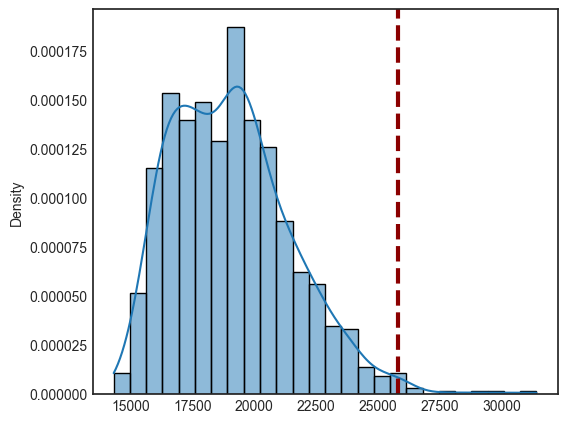

In [302]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.histplot(null_scores, stat="density", kde=True, ax=ax)
ax.axvline(obs_score, color="darkred", linestyle="--", lw=3)

pvalue = (np.sum(null_scores >= obs_score) + 1) / (len(null_scores) + 1)
print(f"p-value: {pvalue:.3g}")

## Fin